In [1]:
import json
import yaml
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
config = yaml.safe_load(open("/gscratch/balazinska/enhaoz/VOCAL-UDF/configs/config.yaml", "r"))

import re
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [2]:
tasks = [f"{i}_new_udfs" for i in range(4)]
for task in tasks:
    accuracy_list = []
    f1_list = []
    precision_list = []
    recall_list = []
    failed_list = []
    for run_id in range(5):
        for question_id in range(10):
            with open(os.path.join(config['output_dir'], "clevr", f"task_{task}_labels_run_{run_id}_question_{question_id}.json"), "r") as f:
                data = json.load(f)
            # "accuracy": 0.9329333333333333, "f1": 0.7679889298892989, "precision": 0.8169774288518155, "recall": 0.7245430809399478, "failed": 0
            accuracy_list.append(data["accuracy"])
            f1_list.append(data["f1"])
            precision_list.append(data["precision"])
            recall_list.append(data["recall"])
            failed_list.append(data["failed"])
            if '0' in task and data["failed"] > 0:
                print(run_id, question_id)
    print(f"task_{task}_mean_accuracy: {np.mean(accuracy_list)}")
    print(f"task_{task}_mean_f1: {np.mean(f1_list)}")
    print(f"task_{task}_mean_precision: {np.mean(precision_list)}")
    print(f"task_{task}_mean_recall: {np.mean(recall_list)}")
    print(f"task_{task}_prob_failures: {np.mean(failed_list) / 15000}")
    print()

1 4
task_0_new_udfs_mean_accuracy: 0.8631973333333335
task_0_new_udfs_mean_f1: 0.6192898766954091
task_0_new_udfs_mean_precision: 0.621786854684621
task_0_new_udfs_mean_recall: 0.7265138743239781
task_0_new_udfs_prob_failures: 0.02

task_1_new_udfs_mean_accuracy: 0.8235960000000001
task_1_new_udfs_mean_f1: 0.20628178243492123
task_1_new_udfs_mean_precision: 0.21059127122499313
task_1_new_udfs_mean_recall: 0.24479415607390273
task_1_new_udfs_prob_failures: 0.62

task_2_new_udfs_mean_accuracy: 0.78328
task_2_new_udfs_mean_f1: 0.0
task_2_new_udfs_mean_precision: 0.0
task_2_new_udfs_mean_recall: 0.0
task_2_new_udfs_prob_failures: 1.0

task_3_new_udfs_mean_accuracy: 0.8365533333333333
task_3_new_udfs_mean_f1: 0.0
task_3_new_udfs_mean_precision: 0.0
task_3_new_udfs_mean_recall: 0.0
task_3_new_udfs_prob_failures: 1.0



######## gpt-4-1106-preview ########
task_0_new_udfs_mean_accuracy: 0.8560279999999999
task_0_new_udfs_mean_f1: 0.7598056863342418
task_0_new_udfs_mean_precision: 0.6282028262122189
task_0_new_udfs_mean_recall: 0.9995976185588176
task_0_new_udfs_prob_failures: 0.0

task_1_new_udfs_mean_accuracy: 0.801991836734694
task_1_new_udfs_mean_f1: 0.3502661125999785
task_1_new_udfs_mean_precision: 0.29020485157028636
task_1_new_udfs_mean_recall: 0.5125681302441962
task_1_new_udfs_prob_failures: 0.3484027210884354

task_2_new_udfs_mean_accuracy: 0.6833946666666665
task_2_new_udfs_mean_f1: 0.38355520138174354
task_2_new_udfs_mean_precision: 0.3019811902632169
task_2_new_udfs_mean_recall: 0.6531573013181416
task_2_new_udfs_prob_failures: 0.296852

task_3_new_udfs_mean_accuracy: 0.7396413333333334
task_3_new_udfs_mean_f1: 0.13972813008025622
task_3_new_udfs_mean_precision: 0.13302555336879324
task_3_new_udfs_mean_recall: 0.23926219204369276
task_3_new_udfs_prob_failures: 0.44

######## gpt-3.5-turbo

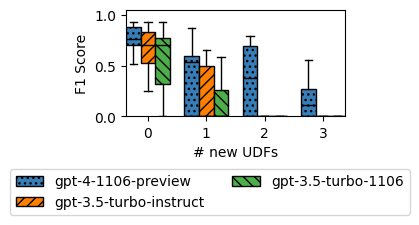

In [3]:
# Define LLM models, tasks, number of new UDFs, and hatch patterns
llm_models = ['gpt-4-1106-preview', 'gpt-3.5-turbo-instruct', 'gpt-3.5-turbo-1106']
tasks = [f"{i}_new_udfs" for i in range(4)]
num_new_udfs = [0, 1, 2, 3]
hatch_patterns = ['...', '///', '\\\\\\', 'xxx']
handles_f1 = []

# Create a figure and axis for the boxplot
fig, ax = plt.subplots(1, 1, figsize=(3, 1.8))  # Adjust the figsize as needed

# Iterate through LLM models
for i, llm_model in enumerate(llm_models):
    print(f"######## {llm_model} ########")
    f1_data = []

    # Iterate through tasks
    for task in tasks:
        accuracy_list = []
        f1_list = []
        precision_list = []
        recall_list = []
        failed_list = []

        # Iterate through runs and questions
        for run_id in range(5):
            for question_id in range(10):
                try:
                    with open(os.path.join(config['output_dir'], "clevr", llm_model, f"task_{task}_labels_run_{run_id}_question_{question_id}.json"), "r") as f:
                        data = json.load(f)
                    accuracy_list.append(data["accuracy"])
                    f1_list.append(data["f1"])
                    precision_list.append(data["precision"])
                    recall_list.append(data["recall"])
                    failed_list.append(data["failed"])
                    if '0' in task and data["failed"] > 0:
                        print(run_id, question_id)
                except:
                    continue

        f1_data.append(f1_list)
        print(f"task_{task}_mean_accuracy: {np.mean(accuracy_list)}")
        print(f"task_{task}_mean_f1: {np.mean(f1_list)}")
        print(f"task_{task}_mean_precision: {np.mean(precision_list)}")
        print(f"task_{task}_mean_recall: {np.mean(recall_list)}")
        print(f"task_{task}_prob_failures: {np.mean(failed_list) / 15000}")
        print()

    # Create a grouped boxplot for F1 scores
    bp_f1 = ax.boxplot(f1_data,
                       positions=np.array(range(len(f1_data))) * (len(llm_models) + 1) + i,
                       sym='.',
                       widths=1,
                       showfliers=False,
                       patch_artist=True,
                       boxprops=dict(facecolor=CB_color_cycle[i], hatch=hatch_patterns[i]),
                       medianprops=dict(color='black'))
    handles_f1.append(bp_f1["boxes"][0])

# Customize the plot labels and legend
ax.set(ylabel="F1 Score")
ax.set(xlabel="# new UDFs")
ax.set_ylim(bottom=0, top=1.05)
ax.set_xticks(np.arange(len(llm_models) / 2 - 0.5, len(num_new_udfs) * len(llm_models) + len(llm_models) / 2 + 0.5, len(llm_models) + 1))
ax.set_xticklabels(num_new_udfs)
fig.legend(handles_f1, llm_models, prop={"size": 10}, loc='upper center', bbox_to_anchor=(0.5, 0.07),
           fancybox=True, shadow=False, ncol=2)
plt.subplots_adjust(bottom=0.15)
fig.tight_layout()
plt.show()